In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Extract data

In [18]:
results = pd.read_csv("all_info.csv", encoding="utf-8")

In [19]:
results

,dataset,aggregator,n_layers,optimizer__lr,n_head,n_hid,dropout,numerical_passthrough,trial,trial_balanced_accuracy_max,training_iter_sec,non_trainable_params,trainable_params,label,balanced_accuracy_train,balanced_accuracy_val,balanced_accuracy_test,n_parameters,n_trainable
0,sylvine,cls,2,0.005615,2,512,0.199337,True,0,0.864333,5.400447,0.0,1070400.0,0,0.973561,0.961200,0.942541,3290721,3290721
1,sylvine,cls,3,0.096973,32,32,0.377600,False,1,0.949579,38.248517,0.0,3290721.0,0,0.973561,0.961200,0.942541,3290721,3290721
2,sylvine,cls,4,0.006356,1,64,0.491456,False,2,0.688080,8.777578,0.0,36225.0,0,0.973561,0.961200,0.942541,3290721,3290721
3,sylvine,cls,2,0.000444,16,32,0.225905,True,3,0.557634,3.126000,0.0,157952.0,0,0.973561,0.961200,0.942541,3290721,3290721
4,sylvine,cls,3,0.000013,4,128,0.029897,False,4,0.501931,7.945999,0.0,3585921.0,0,0.973561,0.961200,0.942541,3290721,3290721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,ldpa,max,4,0.056866,1,1024,0.168485,True,25,0.162316,970.861393,0.0,3169100.0,4,0.440873,0.438302,0.423968,405771,405771
1589,ldpa,max,2,0.001652,4,256,0.374320,False,26,0.311577,711.008068,0.0,2651147.0,4,0.440873,0.438302,0.423968,405771,405771
1590,ldpa,max,1,0.021208,4,256,0.251674,False,27,0.368412,470.559668,0.0,405771.0,4,0.440873,0.438302,0.423968,405771,405771
1591,ldpa,max,2,0.000017,8,256,0.491890,False,28,0.141553,97.329034,0.0,2651147.0,4,0.440873,0.438302,0.423968,405771,405771


# Adding data

In [20]:
results["balanced_accuracy_train_ds"] = results.groupby(["dataset"], group_keys=False)["balanced_accuracy_train"].transform("max")
results["balanced_accuracy_val_ds"] = results.groupby(["dataset"], group_keys=False)["balanced_accuracy_val"].transform("max")
results["balanced_accuracy_test_ds"] = results.groupby(["dataset"], group_keys=False)["balanced_accuracy_test"].transform("max")

In [21]:
results

,dataset,aggregator,n_layers,optimizer__lr,n_head,n_hid,dropout,numerical_passthrough,trial,trial_balanced_accuracy_max,...,trainable_params,label,balanced_accuracy_train,balanced_accuracy_val,balanced_accuracy_test,n_parameters,n_trainable,balanced_accuracy_train_ds,balanced_accuracy_val_ds,balanced_accuracy_test_ds
0,sylvine,cls,2,0.005615,2,512,0.199337,True,0,0.864333,...,1070400.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
1,sylvine,cls,3,0.096973,32,32,0.377600,False,1,0.949579,...,3290721.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
2,sylvine,cls,4,0.006356,1,64,0.491456,False,2,0.688080,...,36225.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
3,sylvine,cls,2,0.000444,16,32,0.225905,True,3,0.557634,...,157952.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
4,sylvine,cls,3,0.000013,4,128,0.029897,False,4,0.501931,...,3585921.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,ldpa,max,4,0.056866,1,1024,0.168485,True,25,0.162316,...,3169100.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538
1589,ldpa,max,2,0.001652,4,256,0.374320,False,26,0.311577,...,2651147.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538
1590,ldpa,max,1,0.021208,4,256,0.251674,False,27,0.368412,...,405771.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538
1591,ldpa,max,2,0.000017,8,256,0.491890,False,28,0.141553,...,2651147.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538


In [22]:
results.columns

Index(['dataset', 'aggregator', 'n_layers', 'optimizer__lr', 'n_head', 'n_hid',
       'dropout', 'numerical_passthrough', 'trial',
       'trial_balanced_accuracy_max', 'training_iter_sec',
       'non_trainable_params', 'trainable_params', 'label',
       'balanced_accuracy_train', 'balanced_accuracy_val',
       'balanced_accuracy_test', 'n_parameters', 'n_trainable',
       'balanced_accuracy_train_ds', 'balanced_accuracy_val_ds',
       'balanced_accuracy_test_ds'],
      dtype='object')

# Correlation matrix

In [23]:
results[[
    "aggregator",
    "n_layers", 
    #"optimizer__lr", 
    "n_head", 
    "n_hid",
    #"dropout", 
    "numerical_passthrough",
    "label"
       ]].corr()

,n_layers,n_head,n_hid,numerical_passthrough,label
n_layers,1.000000,-0.045456,-0.030354,-0.066303,0.021228
n_head,-0.045456,1.000000,-0.003726,-0.045282,0.054108
n_hid,-0.030354,-0.003726,1.000000,-0.008237,-0.070547
numerical_passthrough,-0.066303,-0.045282,-0.008237,1.000000,0.011537
label,0.021228,0.054108,-0.070547,0.011537,1.000000


In [24]:
results

,dataset,aggregator,n_layers,optimizer__lr,n_head,n_hid,dropout,numerical_passthrough,trial,trial_balanced_accuracy_max,...,trainable_params,label,balanced_accuracy_train,balanced_accuracy_val,balanced_accuracy_test,n_parameters,n_trainable,balanced_accuracy_train_ds,balanced_accuracy_val_ds,balanced_accuracy_test_ds
0,sylvine,cls,2,0.005615,2,512,0.199337,True,0,0.864333,...,1070400.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
1,sylvine,cls,3,0.096973,32,32,0.377600,False,1,0.949579,...,3290721.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
2,sylvine,cls,4,0.006356,1,64,0.491456,False,2,0.688080,...,36225.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
3,sylvine,cls,2,0.000444,16,32,0.225905,True,3,0.557634,...,157952.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
4,sylvine,cls,3,0.000013,4,128,0.029897,False,4,0.501931,...,3585921.0,0,0.973561,0.961200,0.942541,3290721,3290721,0.974764,0.961200,0.944894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,ldpa,max,4,0.056866,1,1024,0.168485,True,25,0.162316,...,3169100.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538
1589,ldpa,max,2,0.001652,4,256,0.374320,False,26,0.311577,...,2651147.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538
1590,ldpa,max,1,0.021208,4,256,0.251674,False,27,0.368412,...,405771.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538
1591,ldpa,max,2,0.000017,8,256,0.491890,False,28,0.141553,...,2651147.0,4,0.440873,0.438302,0.423968,405771,405771,0.976939,0.628323,0.616538


# Hyperparameters count

In [25]:
hyperparam_df= results
hyperparam_df = hyperparam_df \
.groupby(["dataset", "aggregator"], group_keys=False) \
.apply(lambda g: g.sort_values(["trial_balanced_accuracy_max"], ascending=False).head(5)) 

In [26]:
hyperparam_df

,dataset,aggregator,n_layers,optimizer__lr,n_head,n_hid,dropout,numerical_passthrough,trial,trial_balanced_accuracy_max,...,trainable_params,label,balanced_accuracy_train,balanced_accuracy_val,balanced_accuracy_test,n_parameters,n_trainable,balanced_accuracy_train_ds,balanced_accuracy_val_ds,balanced_accuracy_test_ds
338,adult,cls,2,0.022613,16,1024,0.237150,False,5,0.693864,...,12760065.0,1,0.760682,0.777153,0.759971,12760065,12760065,0.76085,0.777153,0.760074
337,adult,cls,3,0.016690,32,1024,0.188255,False,4,0.689663,...,19061761.0,1,0.760682,0.777153,0.759971,12760065,12760065,0.76085,0.777153,0.760074
342,adult,cls,2,0.022866,32,1024,0.225134,False,9,0.688826,...,12760065.0,1,0.760682,0.777153,0.759971,12760065,12760065,0.76085,0.777153,0.760074
349,adult,cls,2,0.027425,32,1024,0.332793,False,16,0.683313,...,12760065.0,1,0.760682,0.777153,0.759971,12760065,12760065,0.76085,0.777153,0.760074
336,adult,cls,2,0.022867,32,1024,0.340320,False,3,0.681691,...,12760065.0,1,0.760682,0.777153,0.759971,12760065,12760065,0.76085,0.777153,0.760074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,volkert,sum,1,0.000276,32,512,0.060621,False,29,0.508342,...,1859594.0,0,0.548807,0.522957,0.527160,1859594,1859594,1.00000,0.682959,0.673912
246,volkert,sum,1,0.002354,32,128,0.459723,False,3,0.508188,...,1465994.0,0,0.548807,0.522957,0.527160,1859594,1859594,1.00000,0.682959,0.673912
270,volkert,sum,3,0.000433,32,512,0.181146,False,27,0.495334,...,5015562.0,0,0.548807,0.522957,0.527160,1859594,1859594,1.00000,0.682959,0.673912
264,volkert,sum,1,0.023232,16,128,0.160380,True,21,0.461547,...,1463034.0,0,0.548807,0.522957,0.527160,1859594,1859594,1.00000,0.682959,0.673912


In [27]:
hyperparam_df["dataset"].unique()

array(['adult', 'anneal', 'australian', 'jasmine', 'kr_vs_kp', 'ldpa',
       'nomao', 'sylvine', 'volkert'], dtype=object)

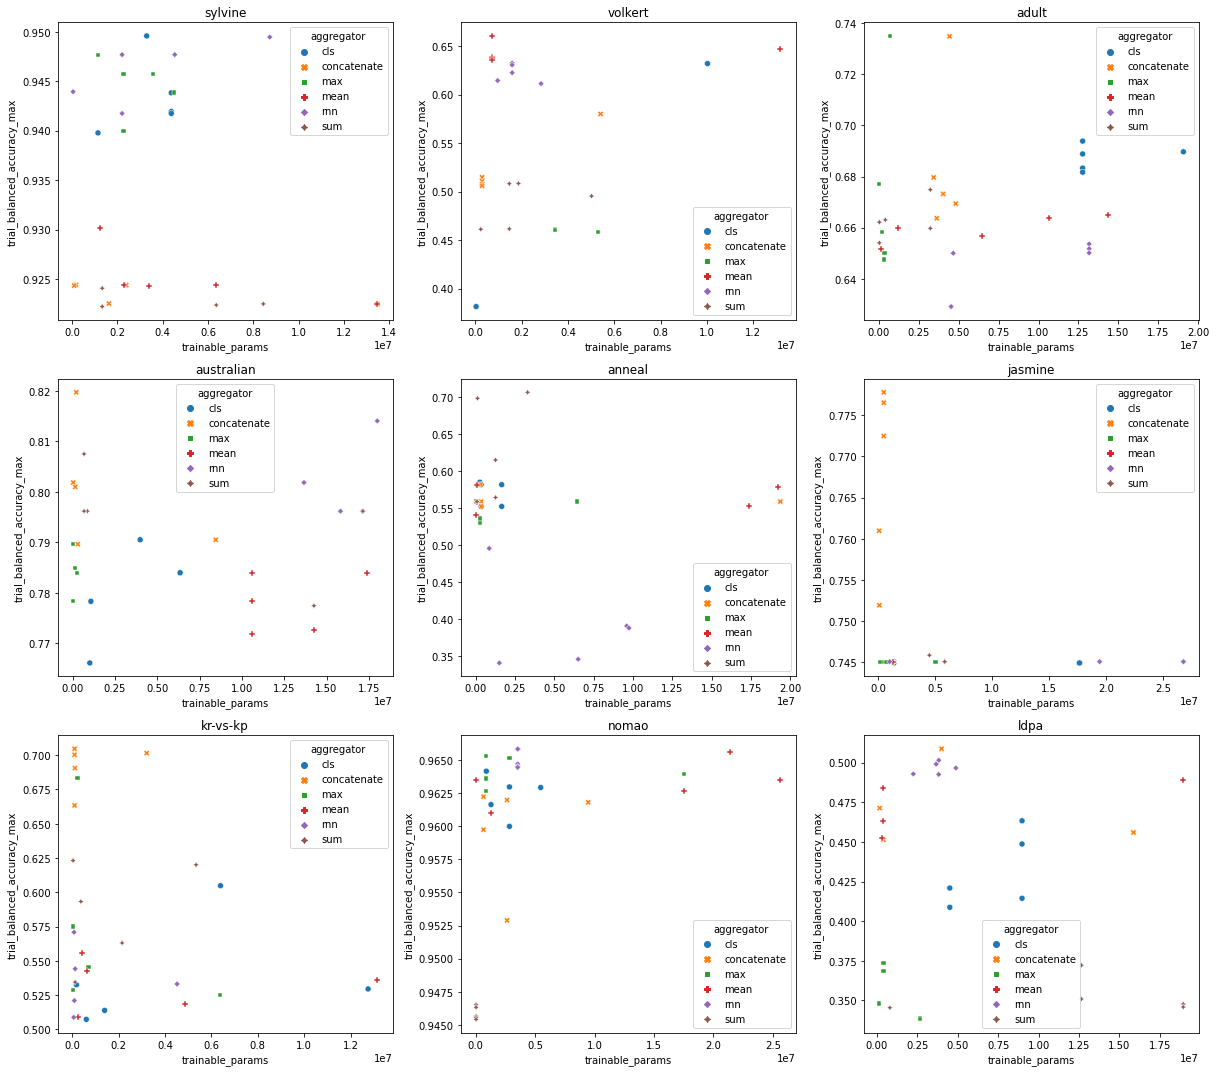

In [28]:
#datasets = hyperparam_df["dataset"].unique()
#datasets = ["sylvine", "volkert", "adult", "australian", "anneal", "jasmine", "kr_vs_kp", "nomao", "ldpa"]
datasets = ["sylvine",  "volkert", "adult", "australian", "anneal", "jasmine", "kr_vs_kp", "nomao", "ldpa"]
aggregators = hyperparam_df["aggregator"].unique()

n_columns = 3
n_rows = math.ceil(len(datasets) / n_columns)

fig, axes = plt.subplots(n_rows, n_columns, figsize=(17, n_columns * 5))

for ds_idx, plot_ds in enumerate(datasets):
    row = math.floor(ds_idx / n_columns)
    col = ds_idx % n_columns
    ax = axes[row, col]

    sns.scatterplot(
        data=hyperparam_df[(hyperparam_df["dataset"] == datasets[ds_idx])], 
        x="trainable_params", 
        y="trial_balanced_accuracy_max", 
        hue="aggregator",
        style="aggregator",
        ax=ax
    )

    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(plot_ds.replace("_", "-"))
    #ax.legend()
    #ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()

# Distribution functions (?)

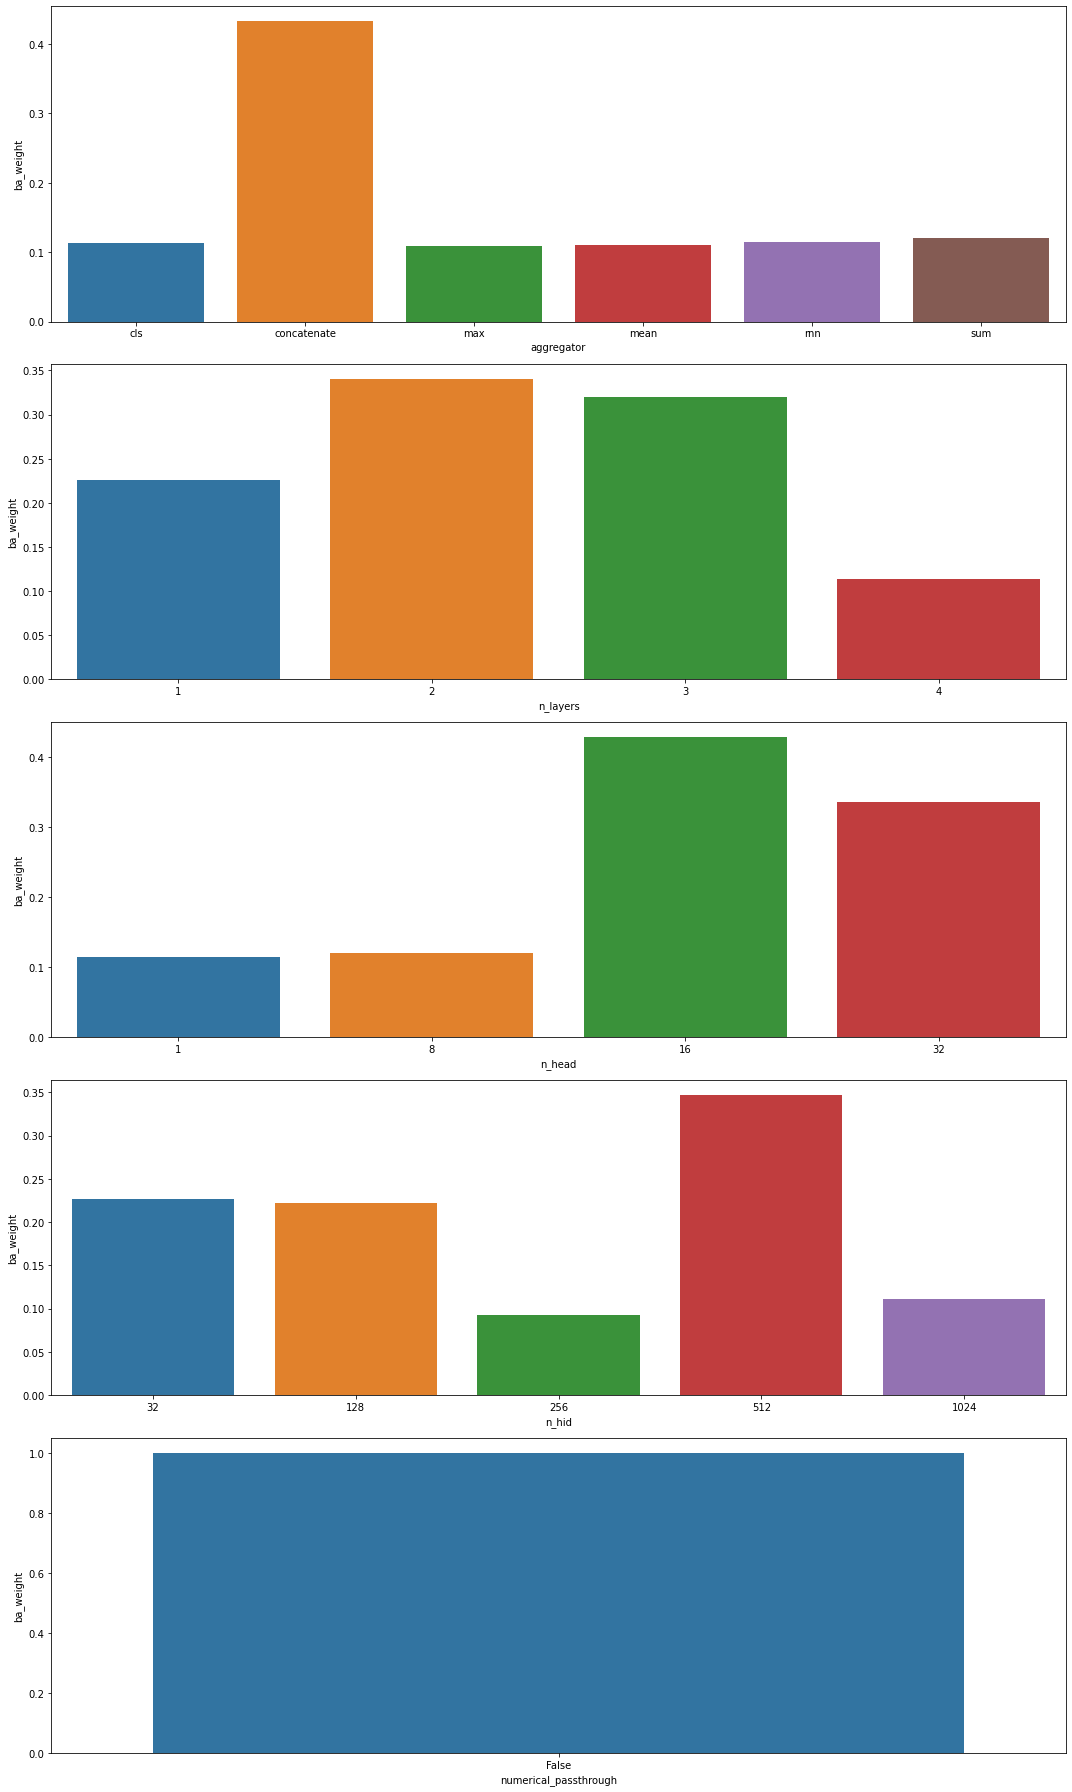

In [29]:

plot_df = results

plot_df = plot_df \
.groupby(["dataset"], group_keys=False) \
.apply(lambda g: g.sort_values(["trial_balanced_accuracy_max"], ascending=False).head(1)) 

plot_df["ba_weight"] = plot_df["trial_balanced_accuracy_max"] / plot_df["balanced_accuracy_val_ds"]
plot_df["ba_weight"] = plot_df["ba_weight"] / plot_df["ba_weight"].sum()
# plot_df["ba_weight"] = np.exp(plot_df["ba_weight"]) / np.exp(plot_df["ba_weight"]).sum()

columns = [
    "aggregator",
    "n_layers", 
    #"optimizer__lr", 
    "n_head", 
    "n_hid",
    #"dropout", 
    "numerical_passthrough",
    #"label"
]

fig, axs = plt.subplots(nrows=len(columns), figsize=(15,len(columns) * 5))

for column_idx, column in enumerate(columns):
    plot_column_df = plot_df \
        .groupby([column], group_keys=False) \
        .sum() \
        .reset_index() 

    sns.barplot(x=plot_column_df[column], y=plot_column_df["ba_weight"], ax=axs[column_idx])
    
fig.tight_layout()

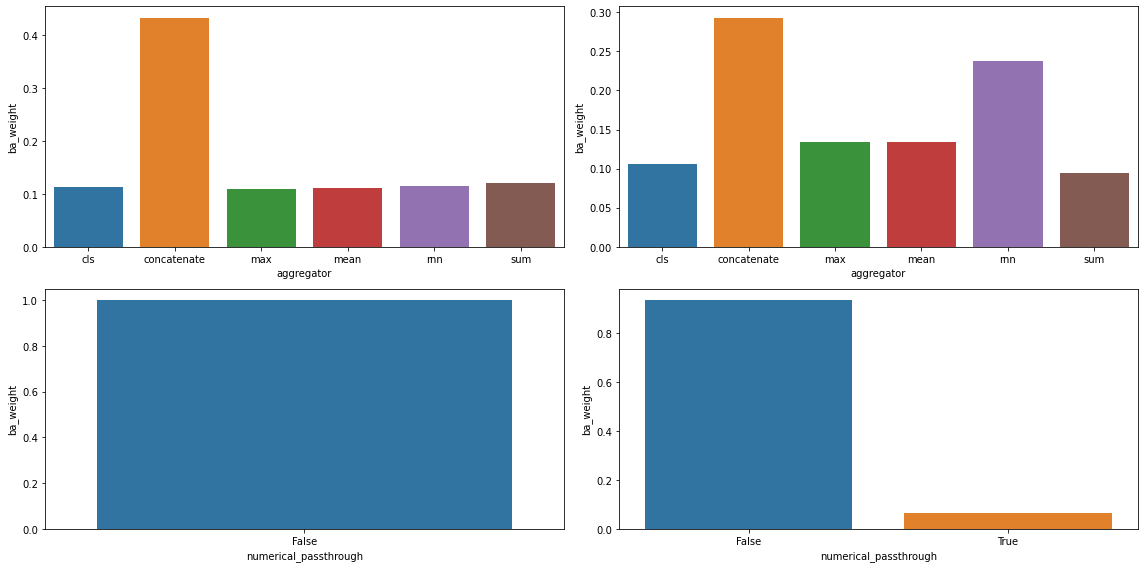

In [33]:

columns = [
        "aggregator",
        #"n_layers", 
        ##"optimizer__lr", 
        #"n_head", 
        #"n_hid",
        ##"dropout", 
        "numerical_passthrough",
        #"label"
    ]

top_k_tests = [1, 5]

n_rows = len(columns)
n_columns = len(top_k_tests)

fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns * 8, n_rows * 4))

for top_k_idx, top_k in enumerate(top_k_tests):
    plot_df = results

    plot_df = plot_df \
    .groupby(["dataset"], group_keys=False) \
    .apply(lambda g: g.sort_values(["trial_balanced_accuracy_max"], ascending=False).head(top_k)) 

    plot_df["ba_weight"] = plot_df["trial_balanced_accuracy_max"] / plot_df["balanced_accuracy_val_ds"]
    plot_df["ba_weight"] = plot_df["ba_weight"] / plot_df["ba_weight"].sum()
    # plot_df["ba_weight"] = np.exp(plot_df["ba_weight"]) / np.exp(plot_df["ba_weight"]).sum()

    for column_idx, column in enumerate(columns):
        plot_column_df = plot_df \
            .groupby([column], group_keys=False) \
            .sum() \
            .reset_index() 

        sns.barplot(x=plot_column_df[column], y=plot_column_df["ba_weight"], ax=axs[column_idx][top_k_idx])
        
fig.tight_layout()

In [31]:
plot_df

,dataset,aggregator,n_layers,optimizer__lr,n_head,n_hid,dropout,numerical_passthrough,trial,trial_balanced_accuracy_max,...,label,balanced_accuracy_train,balanced_accuracy_val,balanced_accuracy_test,n_parameters,n_trainable,balanced_accuracy_train_ds,balanced_accuracy_val_ds,balanced_accuracy_test_ds,ba_weight
486,adult,max,2,0.004431,16,128,0.002493,False,3,0.735000,...,1,0.760682,0.776857,0.758743,698625,698625,0.760850,0.777153,0.760074,0.022211
391,adult,concatenate,1,0.000840,1,32,0.160257,True,28,0.734842,...,1,0.760850,0.777140,0.760074,3439809,3439809,0.760850,0.777153,0.760074,0.022206
338,adult,cls,2,0.022613,16,1024,0.237150,False,5,0.693864,...,1,0.760682,0.777153,0.759971,12760065,12760065,0.760850,0.777153,0.760074,0.020968
337,adult,cls,3,0.016690,32,1024,0.188255,False,4,0.689663,...,1,0.760682,0.777153,0.759971,12760065,12760065,0.760850,0.777153,0.760074,0.020841
342,adult,cls,2,0.022866,32,1024,0.225134,False,9,0.688826,...,1,0.760682,0.777153,0.759971,12760065,12760065,0.760850,0.777153,0.760074,0.020816
811,anneal,sum,2,0.000410,8,512,0.118726,False,28,0.705964,...,2,0.425792,0.668464,0.423474,1263173,1263173,0.448435,0.668464,0.423474,0.024802
809,anneal,sum,1,0.000476,32,64,0.115259,False,26,0.697876,...,2,0.425792,0.668464,0.423474,1263173,1263173,0.448435,0.668464,0.423474,0.024518
792,anneal,sum,1,0.000515,32,64,0.147780,False,9,0.614542,...,2,0.425792,0.668464,0.423474,1263173,1263173,0.448435,0.668464,0.423474,0.021590
711,anneal,cls,3,0.033948,8,512,0.313170,False,18,0.584559,...,2,0.422417,0.581209,0.372582,1654277,1654277,0.448435,0.668464,0.423474,0.020537
863,anneal,max,1,0.076695,16,1024,0.259839,False,20,0.581209,...,2,0.446940,0.595915,0.386948,28421,28421,0.448435,0.668464,0.423474,0.020419


## Accuracy vs hyperparameters search iteration (fail)

In [32]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        
        sorted_by_trial_results = {k: v for k, v in sorted(results[plot_ds][k_agg].items(), key=lambda item: item[1]["trial"])}
        b_accuracies = [sorted_by_trial_results[trial]["balanced_accuracy_max"] for trial in sorted_by_trial_results]

        ax.plot(
            list(results[plot_ds][k_agg].keys()),            
            b_accuracies,
            label=k_agg
        )

#Use adjustable='box-forced' to make the plot area square-shaped as well.
#ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(plot_ds)
    ax.plot()  #Causes an autoscale update.
    ax.legend()
    
fig.tight_layout()
plt.show()

NameError: name 'FIG_COLS' is not defined

## Parameters vs Accuracy

In [ ]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]

    for k_agg_idx, k_agg in enumerate(results[plot_ds]):

        n_params =  [results[plot_ds][k_agg][trial]["trainable_params"] for trial in results[plot_ds][k_agg]]
        b_accuracies = [results[plot_ds][k_agg][trial]["balanced_accuracy_max"] for trial in results[plot_ds][k_agg]]

        ax.scatter(
            n_params,
            b_accuracies,
            marker=["o", "+", "*", "P", "D", "X"][k_agg_idx],
            label=k_agg,
        )

    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(plot_ds)
    ax.legend()
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

## Aggregator vs Accuracy vs Num of params

In [ ]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]

    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        for trial in results[plot_ds][k_agg]:

            ax.add_patch(
                plt.Circle(
                    (k_agg_idx, results[plot_ds][k_agg][trial]["balanced_accuracy_max"]),
                    results[plot_ds][k_agg][trial]["trainable_params"] / 100000000, 
                    color='#000033', 
                    alpha=0.1
                )
            )

    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    ax.set_aspect('equal', adjustable='datalim')
    #ax.set_ylim([0, 1])
    ax.set_title(plot_ds)
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

## Aggregator vs accuracy

In [ ]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    
    means = []
    stds = []
    
    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        
        ax.scatter(
            k_agg, 
            eval_results[plot_ds][k_agg]["balanced_accuracy_val"],
            label=k_agg + "_max",
            marker="+"
        )

        #for trial in results[plot_ds][k_agg]:
        
        b_accs = [results[plot_ds][k_agg][trial]["balanced_accuracy_max"] for trial in results[plot_ds][k_agg]]
        mean = np.mean(b_accs)
        std = np.std(b_accs)
        
        means.append(mean)
        stds.append(std)
        
        
    ax.errorbar(
        list(results[plot_ds].keys()), # Get aggregators
        means, 
        stds, 
        linestyle="None", 
        marker="^"
    )
            
            
    ax.set_title(plot_ds)
    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    #ax.legend()
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

In [ ]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        
        ax.scatter(
            k_agg, 
            eval_results[plot_ds][k_agg]["balanced_accuracy_val"],
            label=k_agg + "_max",
            marker="+"
        )

        for trial in results[plot_ds][k_agg]:

            ax.scatter(
                k_agg, 
                results[plot_ds][k_agg][trial]["balanced_accuracy_max"],
                label=k_agg
            )
            
            
            
    ax.set_title(plot_ds)
    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    #ax.legend()
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

## Aggregator vs train, val, test accuracy

In [ ]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    
    for partition_idx, partition in enumerate(["train", "val", "test"]):        
        x = []
        y = []
    
        for k_agg_idx, k_agg in enumerate(results[plot_ds]):
            x.append(k_agg)
            y.append(eval_results[plot_ds][k_agg]["balanced_accuracy_" + partition])
        
        ax.scatter(
            x, 
            y,
            marker=["o", "+", "*"][partition_idx],
            label=partition
        )
            
    ax.set_title(plot_ds)
    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.plot()   #Causes an autoscale update.

fig.tight_layout()
plt.show()

## Config vs accuracy

In [ ]:
all_configs = []

for k_ds in DATASETS:
    this_config  = {"dataset": k_ds}
    
    for k_agg in results[k_ds]:
        this_config["aggregator"] = k_agg
        
        for k_trial in results[k_ds][k_agg]:
            all_configs.append({
                **this_config, 
                **results[k_ds][k_agg][k_trial]["config"],
                "balanced_accuracy_max": results[k_ds][k_agg][k_trial]["balanced_accuracy_max"]
            })  
    

In [ ]:
config_df = pd.DataFrame(all_configs)
config_df = pd.merge(config_df, ds_info_df, left_on="dataset", right_on="name", how="left")


# One hot encoding
#config_df = pd.get_dummies(config_df, columns=["aggregator"], prefix="aggregator", prefix_sep="_")
#config_df = pd.get_dummies(config_df, columns=["label"], prefix="label", prefix_sep="_")


# Label encoding
config_df["aggregator"] = config_df["aggregator"].astype("category").cat.codes


config_df["numerical_passthrough"] = config_df["numerical_passthrough"].astype("category").cat.codes

In [ ]:
config_df

In [ ]:
config_df.columns

In [ ]:
dropable_columns = [    
    "dataset",
    "name",
    "features_instances", 
    "percent_numerical", 
    "percent_missing_values",
    "label"
]

clean_config_df = config_df.drop(dropable_columns, axis=1) 
config_vectors = clean_config_df.values
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
config_vectors = scaler.fit_transform(config_vectors)

In [ ]:
clean_config_df

# Correlation matrix

In [ ]:
fig = plt.figure(figsize=(11,11))
sns.heatmap(clean_config_df.corr(), vmin=-1, vmax=1, center=0, annot=True, fmt='.2f')

In [ ]:
pca = manifold.TSNE(n_components=2, random_state=11)
#pca = decomposition.PCA(n_components=2, random_state=11)
plot_vectors = pca.fit_transform(config_vectors)

In [ ]:
plt.axis("off")
plt.title("Configurations")
_ = plt.scatter(plot_vectors[:, 0], plot_vectors[:, 1])

# Multiple colorings

In [ ]:
colors = ["red", "black", "purple", "blue", "orange", "cyan", "green", "gray", "pink"]
markers = ['o', 's', 'D', '^', 'v', '*', '.', ',' ]

In [ ]:
list(clean_config_df.keys())

In [ ]:
clean_config_df["dropout"].astype("category")

In [ ]:
fig, axs = plt.subplots(clean_config_df.shape[1] // 3 + 1, 3, figsize=(15, 20))

for ax_idx, ax in enumerate(axs.flat):
    #ax.axis("off")
    
    if ax_idx >= clean_config_df.shape[1]:
        continue 
        
    group_name = str(clean_config_df.keys()[ax_idx])
    color_attributes = clean_config_df[group_name].values.astype(int)

    ax.set_title(f"Configurations grouped by {group_name}")
    for coloring_idx, coloring_attr in enumerate(set(color_attributes)):
        indices = np.argwhere(color_attributes == coloring_attr).flatten()
        _ = ax.scatter(
            plot_vectors[indices, 0], 
            plot_vectors[indices, 1], 
            marker=markers[coloring_idx % len(markers)]
        )
        
fig.tight_layout()

# Clustering

In [ ]:
#clustering = cluster.DBSCAN(eps=1.8)
clustering = cluster.KMeans(n_clusters=5)
clustering.fit(config_vectors)

In [ ]:
colors = ["red", "black", "purple", "blue", "orange", "cyan", "green", "gray", "pink"]
markers = ['o', 's', 'D', '^', 'v', '*', '.', ',' ]
print("Available labels:", set(clustering.labels_))

In [ ]:
plt.axis('off')

plt.title("Datasets clusters")

for label_idx, label in enumerate(set(clustering.labels_)):
    indices = np.argwhere(clustering.labels_ == label).flatten()
    _ = plt.scatter(
        plot_vectors[indices, 0], 
        plot_vectors[indices, 1], 
        marker=markers[label_idx % len(markers)]
    )
    
    #plt.savefig("assets/datasets_clusters.png", dpi=300)